# Data Retrieval


I retrieved daily stock data for 10 selected tickers from Yahoo Finance covering the period from 2020 to 2024 using the `yfinance` package. Each stock’s data was tagged with its ticker and concatenated into a single long-format DataFrame.

To ensure the data was clean and consistent:
- I checked for missing values using `df_long.isnull().sum()` and found no missing entries.
- I verified there were no duplicate rows using `df_long.duplicated().sum()`.

Therefore, no further cleaning actions were necessary at this stage.


### Import Data

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize


plt.style.use("ggplot")


In [37]:
# Define the list of stock tickers
tickers = ["NFLX", "JNJ", "PG", "MCD", "AMZN", "BAC", "JPM", "BSX", "NVDA", "MSFT"]
groups = []

# Download data for each stock and add to the list
for ticker in tickers:
    data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
    data.columns = data.columns.droplevel(1)  # To get rid of the MultiIndex
    data["Ticker"] = ticker  # Add a new column to identify the stock ticker
    groups.append(data)

# Concatenate all the stock data into one DataFrame
df_long = pd.concat(groups)

# Display the concatenated data
print(df_long.head())


df_long.to_csv("stock_data_long_format.csv")



/tmp/ipykernel_1590/3061240889.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_1590/3061240889.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1590/3061240889.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1590/3061240889.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1590/3061240889.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 compl

Price            Close        High         Low        Open   Volume Ticker
Date                                                                      
2020-01-02  329.809998  329.980011  324.779999  326.100006  4485800   NFLX
2020-01-03  325.899994  329.859985  325.529999  326.779999  3806900   NFLX
2020-01-06  335.829987  336.359985  321.200012  323.119995  5663100   NFLX
2020-01-07  330.750000  336.700012  330.299988  336.470001  4703200   NFLX
2020-01-08  339.260010  342.700012  331.049988  331.489990  7104500   NFLX


### Data Cleaning
Now that we have combined the data for the ten stocks into a single DataFrame, it's time to clean the data. We'll follow similar steps to ensure our data is clean and ready for analysis.

In [38]:
print(df_long.isnull().sum())

Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64


In [39]:
# Count the duplicates  
df_long.duplicated().sum()

np.int64(0)

# Data Exploration


#### Multi-Stock Time Series Data (CRSP)


In [40]:
df = pd.read_csv("stock_data_long_format.csv", dayfirst=True)

### Present the head and tail of a wide data frame that shows the closing prices for each stock.

In [41]:
# Pivot the DataFrame to wide format with stocks as columns and dates as index
df_pivot = df.pivot(index="Date", columns="Ticker", values="Close")
df_pivot

# Select 10 stocks
portfolio_stocks = df_pivot.columns[:10] 
df_pivot = df_pivot[portfolio_stocks]


# Set equal weights for each stock in the portfolio.
weights = np.ones(10) / 10

print(df_pivot.head())  
print(df_pivot.tail())  



Ticker           AMZN        BAC        BSX         JNJ         JPM  \
Date                                                                  
2020-01-02  94.900497  31.092318  45.330002  124.983719  120.733574   
2020-01-03  93.748497  30.446745  44.980000  123.536644  119.140343   
2020-01-06  95.143997  30.403114  45.349998  123.382530  119.045578   
2020-01-07  95.343002  30.202473  45.400002  124.136024  117.021729   
2020-01-08  94.598503  30.507807  45.639999  124.118896  117.934616   

Ticker             MCD        MSFT        NFLX      NVDA          PG  
Date                                                                  
2020-01-02  176.811646  153.042282  329.809998  5.971746  107.748230  
2020-01-03  176.186432  151.136658  325.899994  5.876163  107.023582  
2020-01-06  178.167725  151.527298  335.829987  5.900805  107.172005  
2020-01-07  178.431885  150.145706  330.750000  5.972244  106.508461  
2020-01-08  181.320190  152.537338  339.260010  5.983446  106.962471  
Ticke

In [42]:
# Save the pivoted data to a new CSV file.
df_pivot.to_csv("stock_data_pivot.csv")


In [43]:
# Check if the index is in ascending order
print(df_pivot.index.is_monotonic_increasing)


True


### Create a single plot showing the closing prices of all ten stocks over the five year period.


<Figure size 1400x700 with 0 Axes>

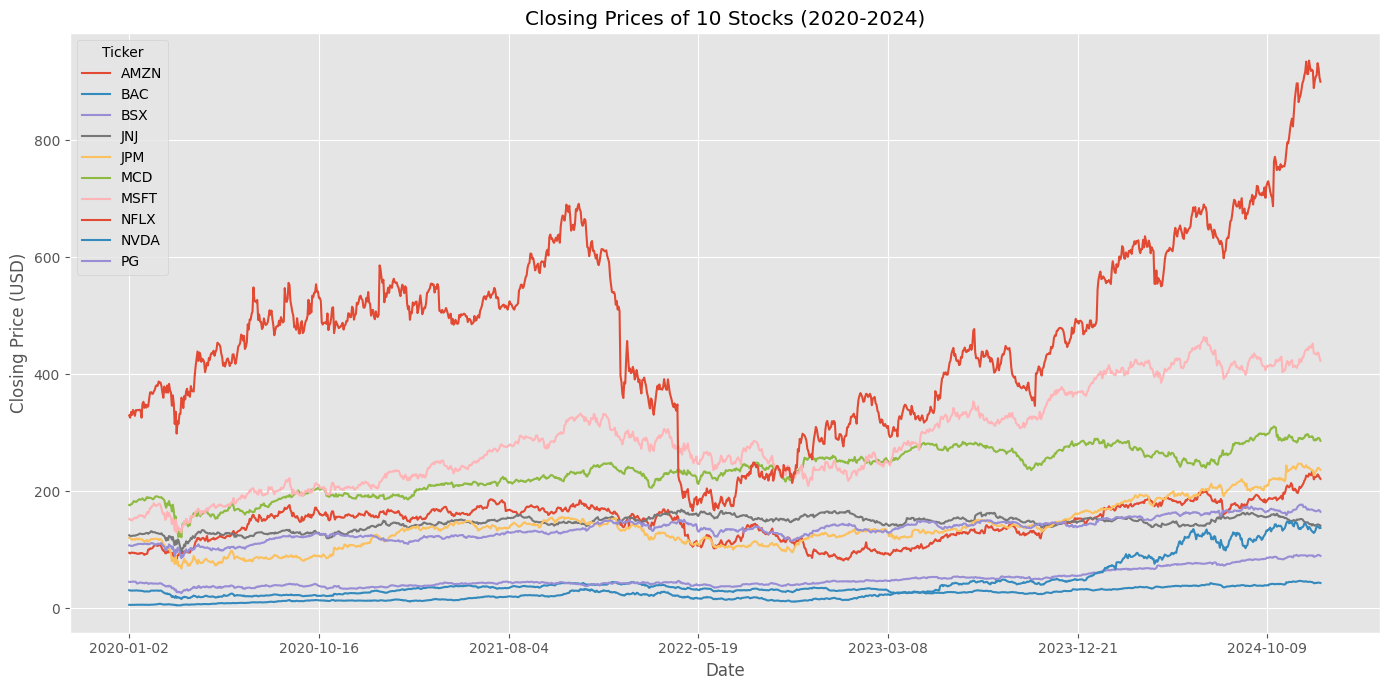

In [44]:

plt.figure(figsize=(14, 7))
df_pivot.plot(title="Closing Prices of 10 Stocks (2020-2024)", figsize=(14, 7))

plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Backtesting

In [45]:

def bollinger_strategy(prices, plot=False):
    df = pd.DataFrame(index=prices.index)
    df["Price"] = prices

    # Calculate 20-day moving average and standard deviation
    df["MA20"] = df["Price"].rolling(20).mean()
    df["STD20"] = df["Price"].rolling(20).std()
    df["Upper"] = df["MA20"] + 2 * df["STD20"]
    df["Lower"] = df["MA20"] - 2 * df["STD20"]

    # Generate buy/sell signals using vectorised logic
    df["Buy"] = (df["Price"] < df["Lower"]).astype(int)
    df["Sell"] = (df["Price"] > df["Upper"]).astype(int) * -1
    df["Signal"] = df["Buy"] + df["Sell"]

    # Forward fill the signals to represent holding positions
    df["Signal"] = df["Signal"].shift(1).fillna(0)


    # Calculate daily returns and strategy returns
    df["Return"] = df["Price"].pct_change()
    df["Strategy"] = df["Signal"].shift(1) * df["Return"]

    # Compute cumulative returns for both strategy and buy & hold
    df["Cumulative_Strategy"] = (1 + df["Strategy"]).cumprod()
    df["Cumulative_BuyHold"] = (1 + df["Return"]).cumprod()

    # Plot the comparison of both strategies 
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(df["Cumulative_Strategy"], label="Strategy")
        plt.plot(df["Cumulative_BuyHold"], label="Buy & Hold")
        plt.title("Bollinger Bands Strategy vs Buy & Hold")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df


In [46]:
# Run strategy for each stock and collect results
results = {}
summary_data = []


for ticker in df_pivot.columns:
    result = bollinger_strategy(df_pivot[ticker])
    results[ticker] = result

    # Extract final cumulative returns
    strategy_return = result["Cumulative_Strategy"].iloc[-1]
    buyhold_return = result["Cumulative_BuyHold"].iloc[-1]

    # Store results for summary table
    summary_data.append({
        "Ticker": ticker,
        "Strategy Return": strategy_return,
        "Buy & Hold Return": buyhold_return
    })

# Create and display summary table
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index("Ticker")
summary_df = summary_df.sort_values("Strategy Return", ascending=False)

summary_df


,Strategy Return,Buy & Hold Return
Ticker,,
BAC,1.065846,1.395168
JNJ,1.053354,1.128091
AMZN,1.025070,2.331916
MSFT,1.021670,2.765268
JPM,1.007307,1.959959
BSX,1.006254,1.978381
PG,0.934585,1.531798
MCD,0.821617,1.619314
NFLX,0.821465,2.730148


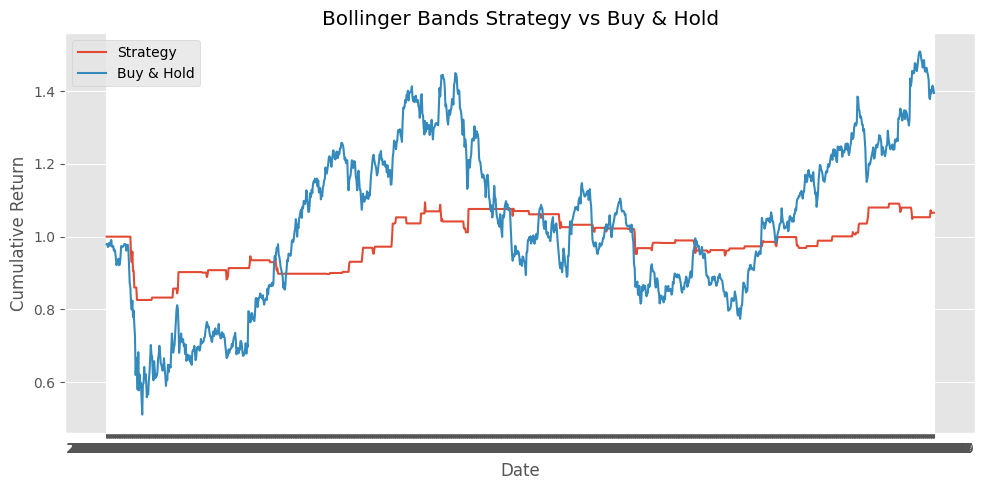

,Price,MA20,STD20,Upper,Lower,Buy,Sell,Signal,Return,Strategy,Cumulative_Strategy,Cumulative_BuyHold
Date,,,,,,,,,,,,
2020-01-02,31.092318,NaN,NaN,NaN,NaN,0,0,0.0,NaN,NaN,NaN,NaN
2020-01-03,30.446745,NaN,NaN,NaN,NaN,0,0,0.0,-0.020763,-0.000000,1.000000,0.979237
2020-01-06,30.403114,NaN,NaN,NaN,NaN,0,0,0.0,-0.001433,-0.000000,1.000000,0.977834
2020-01-07,30.202473,NaN,NaN,NaN,NaN,0,0,0.0,-0.006599,-0.000000,1.000000,0.971381
2020-01-08,30.507807,NaN,NaN,NaN,NaN,0,0,0.0,0.010110,0.000000,1.000000,0.981201
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,43.359241,45.313831,1.273078,47.859987,42.767676,0,0,0.0,-0.006339,-0.006339,1.065846,1.394532
2024-12-24,43.843319,45.172697,1.271747,47.716191,42.629203,0,0,0.0,0.011164,0.000000,1.065846,1.410101
2024-12-26,44.011265,45.027680,1.227620,47.482919,42.572440,0,0,0.0,0.003831,0.000000,1.065846,1.415503


In [62]:
bollinger_strategy(df_pivot["BAC"], plot=True)


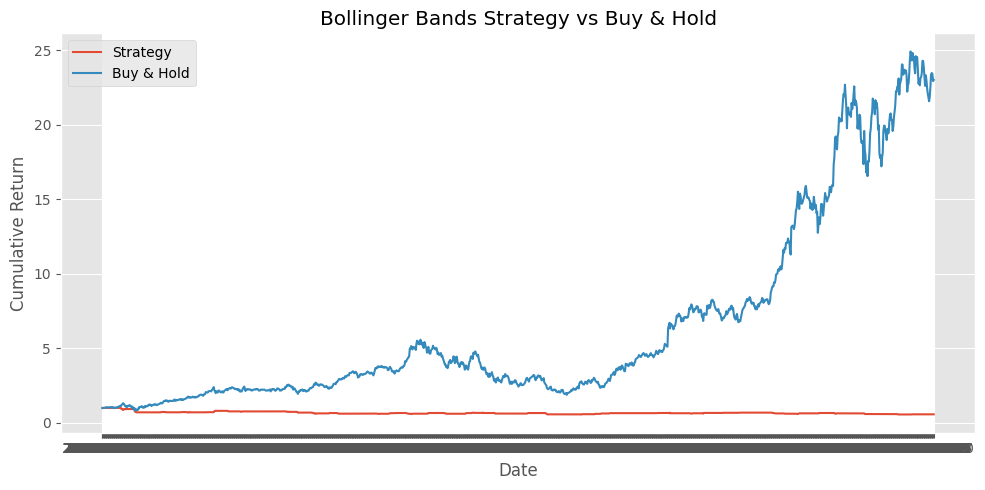

,Price,MA20,STD20,Upper,Lower,Buy,Sell,Signal,Return,Strategy,Cumulative_Strategy,Cumulative_BuyHold
Date,,,,,,,,,,,,
2020-01-02,5.971746,NaN,NaN,NaN,NaN,0,0,0.0,NaN,NaN,NaN,NaN
2020-01-03,5.876163,NaN,NaN,NaN,NaN,0,0,0.0,-0.016006,-0.0,1.000000,0.983994
2020-01-06,5.900805,NaN,NaN,NaN,NaN,0,0,0.0,0.004194,0.0,1.000000,0.988120
2020-01-07,5.972244,NaN,NaN,NaN,NaN,0,0,0.0,0.012107,0.0,1.000000,1.000083
2020-01-08,5.983446,NaN,NaN,NaN,NaN,0,0,0.0,0.001876,0.0,1.000000,1.001959
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,139.647446,136.934048,4.504449,145.942946,127.925151,0,0,0.0,0.036897,0.0,0.567304,23.384693
2024-12-24,140.197372,137.144483,4.555974,146.256431,128.032536,0,0,0.0,0.003938,0.0,0.567304,23.476781
2024-12-26,139.907410,137.295430,4.596873,146.489176,128.101684,0,0,0.0,-0.002068,-0.0,0.567304,23.428225


In [48]:
bollinger_strategy(df_pivot["NVDA"], plot=True)


# Portfolio Management
Visualise the portfolio by plotting the correlation matrix of its simple daily returns.

Create a portfolio of the 10 stocks with equal initial weights.

Calculate the portfolio returns and cumulative returns.

Calculate the daily standard deviation of portfolio returns as a risk measurement.

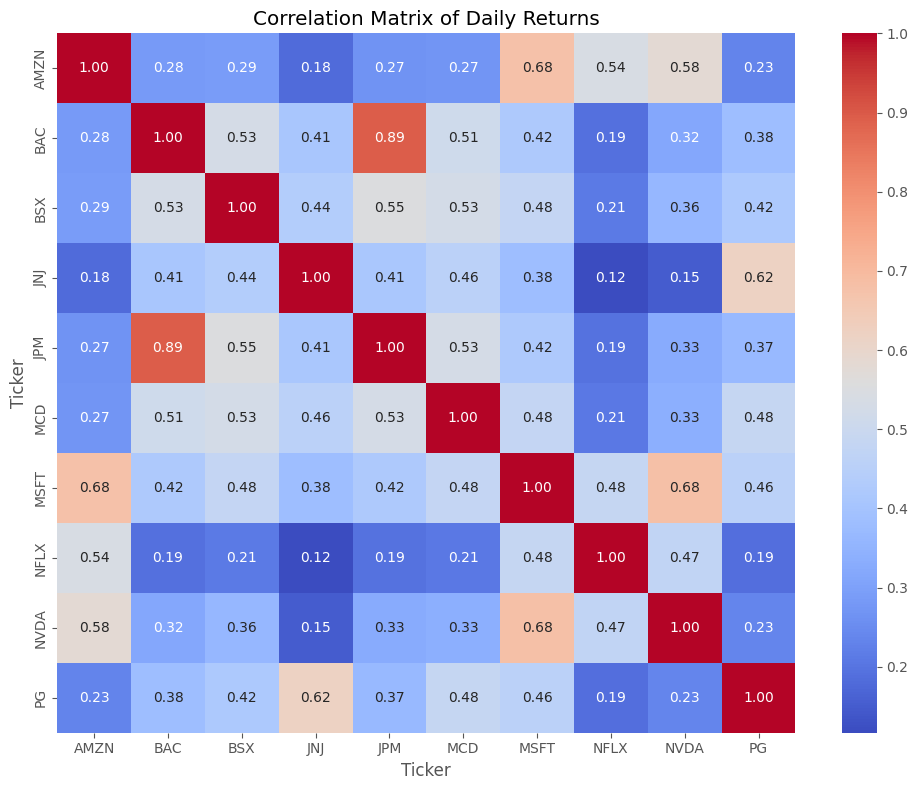

In [49]:
# Daily Returns
daily_returns = df_pivot.pct_change().dropna()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(daily_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.tight_layout()
plt.show()



In [50]:
# Equal-weight Portfolio
weights = np.ones(df_pivot.shape[1]) / df_pivot.shape[1]

portfolio_returns = daily_returns.dot(weights)
portfolio_returns




Date
2020-01-03   -0.011597
2020-01-06    0.006952
2020-01-07   -0.003115
2020-01-08    0.007923
2020-01-09    0.005032
                ...   
2024-12-23    0.004537
2024-12-24    0.011299
2024-12-26   -0.000258
2024-12-27   -0.010346
2024-12-30   -0.009658
Length: 1256, dtype: float64

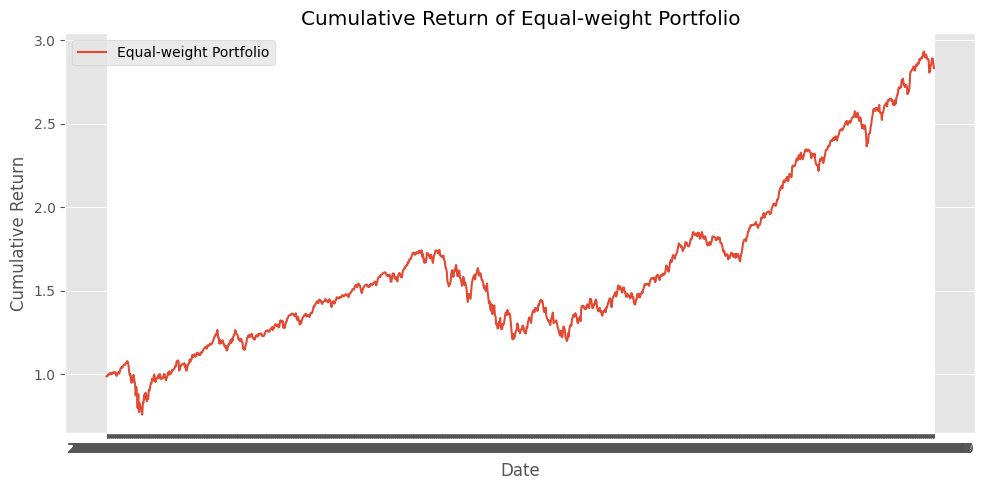

In [51]:
# Cumulative Returns
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label="Equal-weight Portfolio")
plt.title("Cumulative Return of Equal-weight Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Daily Risk (Standard Deviation)
daily_risk = portfolio_returns.std()
print(f"Daily Standard Deviation (Risk): {daily_risk:.4f}")

Daily Standard Deviation (Risk): 0.0140


In [53]:
RFR = 0.043                 # Using 10-Year US Treasury Yield as risk-free rate
TRADING_DAYS = 252

In [54]:
# Equal-weight Portfolio
equal_weights = np.ones(df_pivot.shape[1]) / df_pivot.shape[1]
equal_returns = daily_returns.dot(equal_weights)

annualised_return_eq = equal_returns.mean() * TRADING_DAYS
annualised_volatility_eq = equal_returns.std() * np.sqrt(TRADING_DAYS)

# Sharpe Ratio
sharpe_ratio_eq = (annualised_return_eq - RFR) / annualised_volatility_eq

print(f"Equal Weights: {equal_weights}")
print(f"Equal Annualised Return: {annualised_return_eq}")
print(f"Equal Annualised Volatility: {annualised_volatility_eq}")
print(f"Equal Weights Sharpe Ratio: {sharpe_ratio_eq}")


Equal Weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Equal Annualised Return: 0.23378567906626282
Equal Annualised Volatility: 0.22212202605506412
Equal Weights Sharpe Ratio: 0.8589228292873891


# Portfolio Optimisation

Implement simple portfolio optimisation by maximising the Sharpe Ratio.

In [55]:
# Define objective function (negative Sharpe Ratio)
def negative_sharpe(weights):
    portfolio_returns = np.dot(daily_returns, weights)
    annualised_return = portfolio_returns.mean() * TRADING_DAYS
    annualised_volatility = portfolio_returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (annualised_return - RFR) / annualised_volatility
    return -sharpe  # To maximise Sharpe, I minimise negative Sharpe


# Define constraints and bounds
initial_weights = np.ones(10) / 10
bounds = tuple((0, 1) for x in range(10))
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}


# Optimisation
result = minimize(negative_sharpe, initial_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x
optimal_weights


array([2.63608976e-17, 0.00000000e+00, 4.51917712e-17, 1.00370396e-17,
       3.83017418e-03, 0.00000000e+00, 4.38146229e-18, 1.02575274e-17,
       9.96169826e-01, 3.61138097e-18])

In [61]:
tickers = df_pivot.columns.tolist()


weights_df = pd.DataFrame({
    "Stock": tickers,
    "Optimised Weight": [round(w, 5) for w in optimal_weights]
})

weights_df = weights_df.sort_values(by="Optimised Weight", ascending=False).reset_index(drop=True)
weights_df["Weight (%)"] = weights_df["Optimised Weight"].apply(lambda x: f"{x*100:.2f}%")
weights_df


,Stock,Optimised Weight,Weight (%)
0,NVDA,0.99617,99.62%
1,JPM,0.00383,0.38%
2,BAC,0.00000,0.00%
3,AMZN,0.00000,0.00%
4,JNJ,0.00000,0.00%
5,BSX,0.00000,0.00%
6,MCD,0.00000,0.00%
7,MSFT,0.00000,0.00%
8,NFLX,0.00000,0.00%
9,PG,0.00000,0.00%


In [57]:
# Calculate metrics of the optimised portfolio
opt_port_returns = np.dot(daily_returns, optimal_weights)
annualised_return_opt = opt_port_returns.mean() * TRADING_DAYS
annualised_volatility_opt = opt_port_returns.std() * np.sqrt(TRADING_DAYS)
sharpe_ratio_opt = (annualised_return_opt - RFR) / annualised_volatility_opt


# Final output

print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Annualised Return: {annualised_return_opt}")
print(f"Optimal Annualised Volatility: {annualised_volatility_opt}")
print(f"Optimal Sharpe Ratio: {sharpe_ratio_opt}")


Optimal Weights: [2.63608976e-17 0.00000000e+00 4.51917712e-17 1.00370396e-17
 3.83017418e-03 0.00000000e+00 4.38146229e-18 1.02575274e-17
 9.96169826e-01 3.61138097e-18]
Optimal Annualised Return: 0.7716033101326423
Optimal Annualised Volatility: 0.5370024773901357
Optimal Sharpe Ratio: 1.3567969251719247


# AI


In [58]:
# Provide a list of potential portfolio optimisation strategies that focus on maximising or minimising a specific metric. Focus only on those strategies that leverage SciPy's minimize function. Use only NumPy , Pandas and SciPy . Do not introduce new packages for this task. Ensure syntax style, variable naming, and the overall look & feel match my own code. 
portfolio_strategies = {
    "Maximise Sharpe Ratio": {
        "objective": negative_sharpe,
        "description": "Maximises the Sharpe Ratio by minimising its negative value.",
        "constraints": constraints,
        "bounds": bounds
    },
    "Minimise Volatility": {
        "objective": lambda w: np.dot(w, np.dot(daily_returns.cov() * TRADING_DAYS, w)),
        "description": "Minimises portfolio volatility (risk).",
        "constraints": constraints,
        "bounds": bounds
    },
    "Maximise Return": {
        "objective": lambda w: -np.dot(w, daily_returns.mean() * TRADING_DAYS),
        "description": "Maximises expected return of the portfolio.",
        "constraints": constraints,
        "bounds": bounds
    },
    "Minimise Tracking Error": {
        "objective": lambda w: np.sqrt(np.sum((np.dot(daily_returns, w) - daily_returns.mean())**2)),
        "description": "Minimises tracking error relative to a benchmark.",
        "constraints": constraints,
        "bounds": bounds
    }
}
# Display the portfolio strategies
for strategy, details in portfolio_strategies.items():
    print(f"Strategy: {strategy}")
    print(f"Description: {details['description']}")
    print(f"Constraints: {details['constraints']}")
    print(f"Bounds: {details['bounds']}\n")


#Based on the strategy 'Maximise Sharpe Ratio', please generate the full optimisation code using NumPy, Pandas, and SciPy only. Use SciPy's minimize function. Define the objective function, constraints, and bounds. Use the Sharpe Ratio portfolio optimisation code as a reference point for constructing my solution. Add detailed comments to explain how it works.
def optimise_portfolio(daily_returns, risk_free_rate=0.043, trading_days=252):
    """
    Optimises a portfolio to maximise the Sharpe Ratio using SciPy's minimize function.

    Parameters:
    - daily_returns: DataFrame of daily returns for each stock in the portfolio.
    - risk_free_rate: Annual risk-free rate (default is 0.043, representing 10-Year US Treasury Yield).
    - trading_days: Number of trading days in a year (default is 252).

    Returns:
    - optimal_weights: Array of optimal weights for each stock in the portfolio.
    - annualised_return_opt: Annualised return of the optimised portfolio.
    - annualised_volatility_opt: Annualised volatility of the optimised portfolio.
    - sharpe_ratio_opt: Sharpe Ratio of the optimised portfolio.
    """

    # Define the objective function to maximise Sharpe Ratio
    def negative_sharpe_ai(weights):
        portfolio_returns_ai = np.dot(daily_returns, weights)
        annualised_return_ai = portfolio_returns_ai.mean() * trading_days
        annualised_volatility_ai = portfolio_returns_ai.std() * np.sqrt(trading_days)
        sharpe = (annualised_return_ai - risk_free_rate) / annualised_volatility_ai
        return -sharpe  # To maximise Sharpe, we minimise its negative value

    # Define constraints and bounds
    initial_weights = np.ones(daily_returns.shape[1]) / daily_returns.shape[1]
    bounds = tuple((0, 1) for _ in range(daily_returns.shape[1]))
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}  # Weights must sum to 1

    # Optimisation using SciPy's minimize function
    result_ai = minimize(negative_sharpe_ai, initial_weights, bounds=bounds, constraints=constraints)

    # Extract optimal weights
    optimal_weights_ai = result_ai.x

    # Calculate metrics of the optimised portfolio
    opt_port_returns = np.dot(daily_returns, optimal_weights_ai)
    annualised_return_ai = opt_port_returns.mean() * trading_days
    annualised_volatility_ai = opt_port_returns.std() * np.sqrt(trading_days)
    sharpe_ratio_ai = (annualised_return_ai - risk_free_rate) / annualised_volatility_ai

    return optimal_weights_ai, annualised_return_ai, annualised_volatility_ai, sharpe_ratio_ai
# Run the optimisation function
optimal_weights_ai, annualised_return_ai, annualised_volatility_ai, sharpe_ratio_ai = optimise_portfolio(daily_returns)
# Display the results
print(f"Optimal Weights AI: {optimal_weights_ai}")
print(f"Optimal Annualised Return AI: {annualised_return_ai}")
print(f"Optimal Annualised Volatility AI: {annualised_volatility_ai}")
print(f"Optimal Sharpe Ratio AI: {sharpe_ratio_ai}")
# The above code defines a function to optimise a portfolio using the Sharpe Ratio as the objective function.
# It uses SciPy's `minimize` function to find the optimal weights for each stock in the portfolio.
# The function returns the optimal weights, annualised return, annualised volatility, and Sharpe Ratio of the optimised portfolio.
# The function is then called with the daily returns DataFrame, and the results are printed.
# The final output provides the optimal weights for each stock, the annualised return, annualised volatility, and Sharpe Ratio of the optimised portfolio.



Strategy: Maximise Sharpe Ratio
Description: Maximises the Sharpe Ratio by minimising its negative value.
Constraints: {'type': 'eq', 'fun': <function <lambda> at 0x7cd65c78cfe0>}
Bounds: ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

Strategy: Minimise Volatility
Description: Minimises portfolio volatility (risk).
Constraints: {'type': 'eq', 'fun': <function <lambda> at 0x7cd65c78cfe0>}
Bounds: ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

Strategy: Maximise Return
Description: Maximises expected return of the portfolio.
Constraints: {'type': 'eq', 'fun': <function <lambda> at 0x7cd65c78cfe0>}
Bounds: ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

Strategy: Minimise Tracking Error
Description: Minimises tracking error relative to a benchmark.
Constraints: {'type': 'eq', 'fun': <function <lambda> at 0x7cd65c78cfe0>}
Bounds: ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (

## Visually (by plotting) compare the:
Cumulative Sharpe Ratio optimised portfolio returns

Cumulative portfolio returns optimised using the AI-generated approach

Cumulative initial (equal-weighting) portfolio returns.





In [59]:
# Dayli Returns for all portfolios
portfolio_returns_sharpe = daily_returns.dot(optimal_weights)
portfolio_returns_ai = daily_returns.dot(optimal_weights_ai)
portfolio_returns_equal = daily_returns.dot(equal_weights)

# Calculate cumulative returns for each portfolio
cumulative_returns_sharpe = (1 + portfolio_returns_sharpe).cumprod()
cumulative_returns_ai = (1 + portfolio_returns_ai).cumprod()
cumulative_returns_equal = (1 + portfolio_returns_equal).cumprod()


# Display the results
print(f"Cumulative Sharpe Ratio optimised portfolio returns: {cumulative_returns_sharpe}")
print(f"Cumulative portfolio returns optimised using the AI-generated approach: {cumulative_returns_ai}")
print(f"Cumulative initial (equal-weighting) portfolio returns: {cumulative_returns_equal}")



Cumulative Sharpe Ratio optimised portfolio returns: Date
2020-01-03     0.984005
2020-01-06     0.988112
2020-01-07     0.999965
2020-01-08     1.001863
2020-01-09     1.012838
                ...    
2024-12-23    23.224247
2024-12-24    23.316816
2024-12-26    23.269081
2024-12-27    22.784650
2024-12-30    22.863498
Length: 1256, dtype: float64
Cumulative portfolio returns optimised using the AI-generated approach: Date
2020-01-03     0.984005
2020-01-06     0.988112
2020-01-07     0.999965
2020-01-08     1.001863
2020-01-09     1.012838
                ...    
2024-12-23    23.224247
2024-12-24    23.316816
2024-12-26    23.269081
2024-12-27    22.784650
2024-12-30    22.863498
Length: 1256, dtype: float64
Cumulative initial (equal-weighting) portfolio returns: Date
2020-01-03    0.988403
2020-01-06    0.995274
2020-01-07    0.992174
2020-01-08    1.000035
2020-01-09    1.005067
                ...   
2024-12-23    2.859327
2024-12-24    2.891634
2024-12-26    2.890887
2024-12-27 

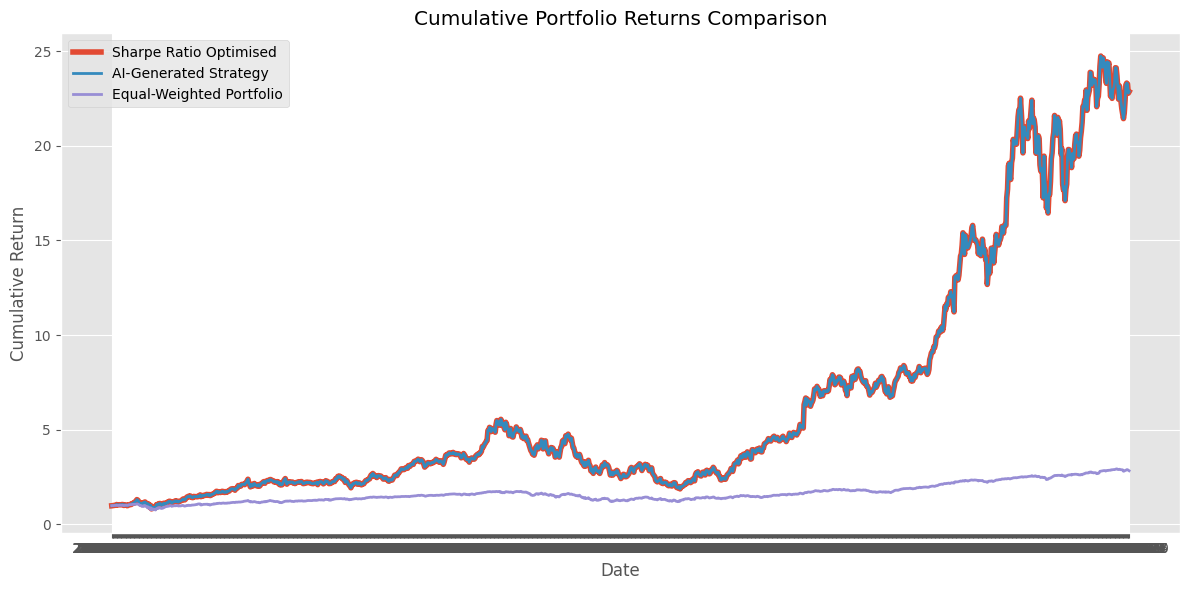

In [60]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_sharpe, label="Sharpe Ratio Optimised", linewidth=4)
plt.plot(cumulative_returns_ai, label="AI-Generated Strategy", linewidth=2)
plt.plot(cumulative_returns_equal, label="Equal-Weighted Portfolio", linewidth=2)

plt.title("Cumulative Portfolio Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()